In [1]:
import pandas as pd
import torch

In [2]:
data_path = "data/soc-sign-epinions.txt"
with open(data_path, "r") as f:
    all_txt_str = f.read().split("\n")

    # remove first 4 lines meta information
    txt_list = [txt_str.split("\t") for txt_str in all_txt_str[4:]]
    edge_df = pd.DataFrame(txt_list, columns=["FromNodeId","ToNodeId","Sign"])

In [3]:
# preprocessing of data
edge_df = edge_df.dropna()
edge_df["FromNodeId"] = edge_df["FromNodeId"].apply(int)
edge_df["ToNodeId"] = edge_df["ToNodeId"].apply(int)
edge_df["Sign"] = edge_df["Sign"].map({"1":1, "-1":0})

In [4]:
# undersampling with 1.5:1 ratio
Sign0_df = edge_df[edge_df["Sign"]==0]
node_set = set(Sign0_df["ToNodeId"])|set(Sign0_df["FromNodeId"])
choose_df = edge_df[edge_df["FromNodeId"].isin(node_set)&edge_df["ToNodeId"].isin(node_set)]

ChooseSign0_df = choose_df[choose_df["Sign"]==0]
ChooseSign1_df = choose_df[choose_df["Sign"]==1]
ChooseSign1_df = ChooseSign1_df.sample(int(len(ChooseSign0_df)*1.5))
choose_df = pd.concat([ChooseSign0_df, ChooseSign1_df]).sample(frac=1)

In [5]:
class IdEncoder:
    def __init__(self, NodeName_set):
        self.NodeId_dict = {
            NodeName: idx for idx, NodeName in enumerate(sorted(NodeName_set))
        }

    def __len__(self):
        return len(self.NodeId_dict)

    @property
    def NodeName_set(self):
        return set(self.NodeId_dict.keys())

    @property
    def max_id(self):
        return max(self.NodeId_dict.values())

    @property
    def IdNode_dict(self):
        return {idx:NodeName for NodeName, idx in self.NodeId_dict.items()}

    def node_to_id(self, node):
        return self.NodeId_dict.get(node)

    def id_to_node(self, id):
        for NodeName, idx in self.NodeId_dict.items():
            if idx==id: return NodeName
        return None

In [6]:
# encode
encode = IdEncoder(node_set)
from_list = choose_df["FromNodeId"].map(encode.NodeId_dict).tolist()
to_list = choose_df["ToNodeId"].map(encode.NodeId_dict).tolist()
sign_list = choose_df["Sign"].tolist()

print(node_set)
# get tensors from dataframe
node_attr_ts = torch.ones(len(encode)).float().reshape(-1, 1)
edge_index_ts = torch.tensor([from_list, to_list]).long()
edge_label_ts = torch.tensor(sign_list).float().reshape(-1, 1)

print(node_attr_ts.shape)
print(node_attr_ts)
print(edge_index_ts.shape)
print(edge_index_ts)
print(edge_label_ts.shape)
print(edge_label_ts)


{0, 1, 131072, 131076, 5, 131078, 7, 8, 131081, 4, 131083, 6, 10, 14, 131087, 131079, 131089, 18, 131086, 20, 21, 22, 23, 131088, 25, 26, 27, 131100, 131096, 131099, 31, 33, 34, 35, 131109, 131110, 39, 131111, 41, 42, 43, 44, 47, 48, 131121, 50, 131123, 52, 53, 54, 131126, 56, 57, 131130, 55, 131133, 63, 64, 65, 66, 67, 68, 69, 74, 75, 76, 77, 131149, 79, 131152, 81, 80, 83, 87, 88, 131161, 90, 91, 93, 94, 95, 19, 131169, 131168, 99, 100, 101, 131174, 102, 104, 105, 106, 131179, 108, 113, 131185, 115, 116, 131188, 118, 131189, 120, 121, 122, 117, 119, 126, 128, 130, 131, 133, 131206, 135, 131207, 131208, 137, 139, 140, 141, 131214, 143, 144, 145, 131218, 147, 142, 149, 146, 131222, 153, 131226, 155, 131228, 131225, 158, 159, 160, 161, 131234, 163, 164, 167, 168, 169, 131240, 170, 131244, 131242, 131239, 175, 176, 177, 173, 131251, 174, 181, 183, 131256, 185, 131258, 187, 189, 190, 192, 131265, 194, 193, 196, 131268, 131270, 199, 197, 201, 202, 203, 131275, 205, 207, 131280, 209, 208, 1

In [7]:
from torch_geometric.data import Data

data = Data(x=node_attr_ts, edge_index=edge_index_ts, edge_attr=edge_label_ts, edge_label=edge_label_ts)

In [8]:
from torch_geometric.transforms import RandomLinkSplit

train_data, val_data, test_data = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=False,
    neg_sampling_ratio=0.0,
    disjoint_train_ratio=0.2,
)(data)

In [13]:
from torch_geometric.nn.models import GraphSAGE #GATv2Conv
from torch_geometric.nn.dense import Linear
import torch.nn.functional as F

# class GATEncoder(torch.nn.Module):
#     def __init__(self, encoder_size):
#         super().__init__()

#         hidden_channels, out_channels = encoder_size
#         self.conv1 = GATv2Conv(
#             (-1, -1), hidden_channels, edge_dim=1, add_self_loops=False
#         )
#         self.lin1 = Linear(-1, hidden_channels)
#         self.conv2 = GATv2Conv(
#             (-1, -1), out_channels, edge_dim=1, add_self_loops=False
#         )
#         self.lin2 = Linear(-1, out_channels)
#         self.conv3 = GATv2Conv(
#             (-1, -1), out_channels, edge_dim=1, add_self_loops=False
#         )
#         self.lin3 = Linear(-1, out_channels)
#         self.conv4 = GATv2Conv(
#             (-1, -1), out_channels, edge_dim=1, add_self_loops=False
#         )
#         self.lin4 = Linear(-1, out_channels)

#     def forward(self, x, edge_index, edge_attr):
#         x = self.conv1(x, edge_index, edge_attr) + self.lin1(x)
#         x = x.relu()
#         x = self.conv2(x, edge_index, edge_attr) + self.lin2(x)
#         x = x.relu()
#         x = self.conv3(x, edge_index, edge_attr) + self.lin3(x)
#         x = x.relu()
#         x = self.conv4(x, edge_index, edge_attr) + self.lin4(x)
#         x = x.relu()
#         return x

class EdgeDecoder(torch.nn.Module):

    def __init__(self, decoder_size):
        super().__init__()
        hidden_channels = decoder_size
        self.lin1 = Linear(-1, hidden_channels)
        self.lin2 = Linear(-1, 1)

    def forward(self, NodeConvH_ts, edge_label_index):
        from_ts, to_ts = edge_label_index
        NodeH_ts = torch.cat([NodeConvH_ts[from_ts], NodeConvH_ts[to_ts]], dim=-1)
        x = self.lin1(NodeH_ts).relu()
        x = self.lin2(x).sigmoid()
        return x

class GNN(torch.nn.Module):
    def __init__(self, encoder_size, decoder_size):
        super().__init__()
        hidden_channels, out_channels = encoder_size
        self.encoder = GraphSAGE(-1, hidden_channels, 3, out_channels, 0.2)
        self.decoder = EdgeDecoder(decoder_size)

    def forward(self, x, edge_index, edge_attr, edge_label_index):
        NodeConvH_ts = self.encoder(x, edge_index, edge_attr)
        return self.decoder(NodeConvH_ts, edge_label_index)

Epoch: 000, Loss: 0.6845, val_Loss: 0.6804
Epoch: 001, Loss: 0.6804, val_Loss: 0.6770
Epoch: 002, Loss: 0.6767, val_Loss: 0.6738
Epoch: 003, Loss: 0.6739, val_Loss: 0.6713
Epoch: 004, Loss: 0.6711, val_Loss: 0.6702
EarlyStopping counter: 1 out of 30
Epoch: 005, Loss: 0.6701, val_Loss: 0.6706
EarlyStopping counter: 2 out of 30
Epoch: 006, Loss: 0.6701, val_Loss: 0.6715
EarlyStopping counter: 3 out of 30
Epoch: 007, Loss: 0.6720, val_Loss: 0.6716
EarlyStopping counter: 4 out of 30
Epoch: 008, Loss: 0.6717, val_Loss: 0.6708
Epoch: 009, Loss: 0.6708, val_Loss: 0.6699
Epoch: 010, Loss: 0.6696, val_Loss: 0.6691
Epoch: 011, Loss: 0.6685, val_Loss: 0.6688
Epoch: 012, Loss: 0.6690, val_Loss: 0.6687
Epoch: 013, Loss: 0.6685, val_Loss: 0.6686
Epoch: 014, Loss: 0.6689, val_Loss: 0.6682
Epoch: 015, Loss: 0.6684, val_Loss: 0.6676
Epoch: 016, Loss: 0.6677, val_Loss: 0.6668
Epoch: 017, Loss: 0.6669, val_Loss: 0.6662
Epoch: 018, Loss: 0.6655, val_Loss: 0.6658
Epoch: 019, Loss: 0.6653, val_Loss: 0.6656


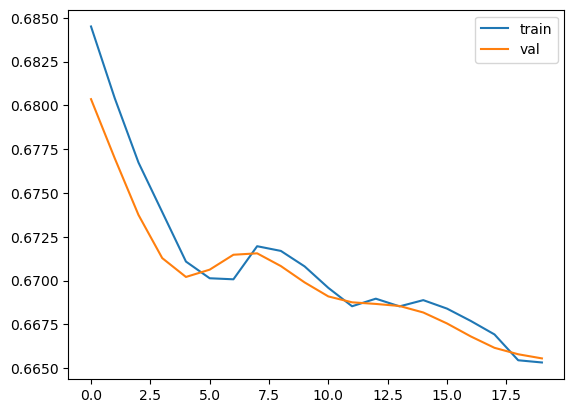

In [19]:
from EarlyStopping import EarlyStopping
import matplotlib.pyplot as plt

def get_pred(data, model):
    return model(
        x=data.x,
        edge_index=data.edge_index,
        edge_attr=data.edge_attr,
        edge_label_index=data.edge_label_index
    )

@torch.no_grad()
def get_pred_no_grad(data, model):
    return model(
        x=data.x,
        edge_index=data.edge_index,
        edge_attr=data.edge_attr,
        edge_label_index=data.edge_label_index
    )

@torch.no_grad()
def get_loss_in_eval(data, model):
    model.eval()
    pred = get_pred_no_grad(data, model)
    target = data.edge_label.reshape(-1, 1)
    loss = torch.nn.functional.binary_cross_entropy(pred, target)
    return loss

def get_loss(data, model):
    pred = get_pred(data, model)
    target = data.edge_label.reshape(-1, 1)
    loss = torch.nn.functional.binary_cross_entropy(pred, target)
    return loss

model = GNN((4, 6), 12)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
early_stopping = EarlyStopping(patience=30, verbose=False)

trainLoss_list = []
valLoss_list = []

for epoch in range(0, 20):
    model.train()
    optimizer.zero_grad()

    train_loss = get_loss(train_data, model)
    train_loss.backward()

    optimizer.step()
    scheduler.step(train_loss)

    val_loss = get_loss_in_eval(val_data, model)

    trainLoss_list.append(train_loss.detach().numpy())
    valLoss_list.append(val_loss.detach().numpy())

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, val_Loss: {val_loss:.4f}')

plt.plot(trainLoss_list, label='train')
plt.plot(valLoss_list, label='val')
plt.legend()
plt.show()

In [ ]:
model = GNN((4, 6), 12)
checkpoint = torch.load("checkpoint.pt")
print(type(checkpoint))
model.load_state_dict(torch.load("checkpoint.pt", weights_only=True))
model.eval()
test_pred = get_pred_no_grad(test_data, model)
test_label = test_data.edge_label.reshape(-1, 1)
test_loss = get_loss_in_eval(test_data, model)
test_loss

<class '__main__.GNN'>


TypeError: Expected state_dict to be dict-like, got <class '__main__.GNN'>.